In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import cv2

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
# INPUT PATHS:
BASE = 'data/'

imgs = []
labels = []
for i in range(1, 41):
    for j in range(1, 11):
        img = cv2.imread(BASE + f's{i}/{j}.pgm', 0)
        imgs.append(img)
        labels.append(i-1)
        
X = np.stack(imgs)
y = np.array(labels)

In [3]:
class DataSet(Dataset):
    """
    This class allows you to convert numpy.array to torch.Dataset
    """

    def __init__(self, x, y, transform=None):
        """
        Attriutes
            x (np.array) :
            y (np.array) :
            transform (torch.transform)
        """
        self.x = x
        self.y = y
        self.transform = transform

    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]

        if self.transform is not None:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.x)

In [4]:
# ToTensor：画像のグレースケール化（RGBの0~255を0~1の範囲に正規化）、Normalize：Z値化（RGBの平均と標準偏差を0.5で決め打ちして正規化）
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, ), (0.5, ))])

trainset = DataSet(X, y, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fla = nn.Flatten()
        self.fc = nn.Linear(112*92, 40)

    def forward(self, x):
        x = self.fla(x)
        x = self.fc(x)
        x = F.softmax(x, dim=1)
        return x
    
net = Net()

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9)

for epoch in range(30):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        #train_loss = loss.item()
        #print('[%d, %5d] loss: %.3f' %
        #          (epoch + 1, i + 1, train_loss))

print('Finished Training')


in_preds = []
in_label = []
with torch.no_grad():
        for data in trainloader:
            inputs, labels = data
            outputs = net(inputs)
            in_preds.append(outputs)
            in_label.append(labels)  
        in_preds = torch.cat(in_preds)
        in_label = torch.cat(in_label)  
print(accuracy_score(np.array(torch.argmax(in_preds, axis=1)),
                     np.array(in_label)))


/opt/conda/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


Finished Training
0.975


In [7]:
from model_inversion import Model_inversion

In [8]:
input_shape = (1, 1, 112, 92)
target_label_1 = 1
target_label_2 = 10
lam = 0.1
num_itr = 100
mi = Model_inversion(net, input_shape)
x_result_1, log = mi.attack(target_label_1, lam, num_itr)
x_result_2, log = mi.attack(target_label_2, lam, num_itr)

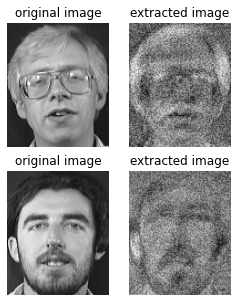

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(4, 5))
axes[0][0].imshow(cv2.imread(BASE + f's2/1.pgm', 0), cmap='gray')
axes[0][0].axis('off')
axes[0][0].set_title('original image')
axes[0][1].imshow(x_result_1[0][0], cmap='gray')
axes[0][1].axis('off')
axes[0][1].set_title('extracted image')

axes[1][0].imshow(cv2.imread(BASE + f's11/1.pgm', 0), cmap='gray')
axes[1][0].axis('off')
axes[1][0].set_title('original image')
axes[1][1].imshow(x_result_2[0][0], cmap='gray')
axes[1][1].axis('off')
axes[1][1].set_title('extracted image')
plt.savefig("model_inversion.png")
plt.show()